In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

1. Data loading and cleaning

In [9]:
# load data from CSV file for data explortion. 

df = pd.read_csv("data/marketing_campaign.csv", sep="\t")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [19]:
null_data = df.isnull().sum()
print(null_data)

ID                           0
Year_Birth                   0
Education                    0
Marital_Status               0
Income                      24
Kidhome                      0
Teenhome                     0
Dt_Customer               1324
Recency                      0
MntWines                     0
MntFruits                    0
MntMeatProducts              0
MntFishProducts              0
MntSweetProducts             0
MntGoldProds                 0
NumDealsPurchases            0
NumWebPurchases              0
NumCatalogPurchases          0
NumStorePurchases            0
NumWebVisitsMonth            0
AcceptedCmp3                 0
AcceptedCmp4                 0
AcceptedCmp5                 0
AcceptedCmp1                 0
AcceptedCmp2                 0
Complain                     0
Z_CostContact                0
Z_Revenue                    0
Response                     0
Age                          0
Children                     0
TotalSpend                   0
MntWines

In [20]:
# drop rows where Income is null
df = df.dropna(subset=['Income']).reset_index(drop=True)


## 2. Feature Engineering
We derive **Age**, **Children**, **TotalSpend**, per-category spend share, and **Tenure**.
We also calculate a simple **PromoAcceptanceRate** to summarize campaign uptake.

In [21]:
# Current year
CURRENT_YEAR = 2025

df['Age'] = CURRENT_YEAR - df['Year_Birth']
df['Children'] = df['Kidhome'] + df['Teenhome']

spend_cols = ['MntWines','MntFruits','MntMeatProducts',
              'MntFishProducts','MntSweetProducts','MntGoldProds']
df['TotalSpend'] = df[spend_cols].sum(axis=1)

#spend_cols = df['Mnt*'].sum(axis=1)

# Avoid division by zero
df['TotalSpend'] = df['TotalSpend'].replace(0, 1)
for col in spend_cols:
    df[f'{col}_share'] = df[col] / df['TotalSpend']

# Customer tenure in days
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')
df['Tenure'] = (pd.to_datetime('today') - df['Dt_Customer']).dt.days

# Campaign acceptance rate
cmp_cols = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response']
df['PromoAcceptanceRate'] = df[cmp_cols].sum(axis=1) / len(cmp_cols)


## 3. Select Features for Clustering

Focus on **behavior and value** (spend, recency, channels), with optional promo rate.

In [22]:
features = [
    'Age','Income','Children','TotalSpend','Recency','Tenure',
    'NumDealsPurchases','NumWebPurchases','NumCatalogPurchases',
    'NumStorePurchases','NumWebVisitsMonth','PromoAcceptanceRate',
    'MntWines_share','MntMeatProducts_share'
]

X = df[features].fillna(0)

# optional log for heavy tails
X['Income'] = np.log1p(X['Income'])
X['TotalSpend'] = np.log1p(X['TotalSpend'])


## 4. Standardize Data


In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 5. Run K-Means (5 clusters)

In [24]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['Segment'] = kmeans.fit_predict(X_scaled)

df['Segment'].value_counts()

Segment
0    541
2    530
1    516
3    465
4    164
Name: count, dtype: int64

## 6. Profile Clusters

Compute mean & median per feature and cluster size.

In [25]:
profile_cols = [
    'Age','Income','Children','TotalSpend','Recency','Tenure',
    'NumDealsPurchases','NumWebPurchases','NumCatalogPurchases',
    'NumStorePurchases','NumWebVisitsMonth'
]

# aggregate and round
cluster_summary = df.groupby('Segment')[profile_cols].agg(['mean','median']).round(1)

# flatten MultiIndex
cluster_summary.columns = [f'{col}_{stat}' for col, stat in cluster_summary.columns]

# add count per cluster
cluster_summary['count'] = df['Segment'].value_counts().sort_index()

# optional: reorder count to first column
cols = ['count'] + [c for c in cluster_summary.columns if c != 'count']
cluster_summary = cluster_summary[cols]

pd.set_option('display.max_columns', None)
cluster_summary


,count,Age_mean,Age_median,Income_mean,Income_median,Children_mean,Children_median,TotalSpend_mean,TotalSpend_median,Recency_mean,Recency_median,Tenure_mean,Tenure_median,NumDealsPurchases_mean,NumDealsPurchases_median,NumWebPurchases_mean,NumWebPurchases_median,NumCatalogPurchases_mean,NumCatalogPurchases_median,NumStorePurchases_mean,NumStorePurchases_median,NumWebVisitsMonth_mean,NumWebVisitsMonth_median
Segment,,,,,,,,,,,,,,,,,,,,,,,
0,541,59.5,59.0,56527.2,56796.0,1.3,1.0,734.4,637.0,47.6,48.0,4519.2,4538.0,4.2,4.0,6.7,7.0,2.9,2.0,7.4,7.0,6.3,6.0
1,516,57.9,58.0,73137.5,72067.0,0.3,0.0,1154.5,1122.0,51.0,54.0,4427.9,4446.0,1.5,1.0,4.7,4.0,5.5,5.0,8.6,9.0,2.7,2.0
2,530,47.7,47.0,27202.8,26907.0,0.9,1.0,85.2,58.0,49.6,50.0,4444.5,4441.0,1.9,1.0,2.1,2.0,0.4,0.0,3.0,3.0,7.1,7.0
3,465,60.6,60.0,42849.9,41335.0,1.6,2.0,99.8,68.0,49.4,49.0,4360.7,4351.0,2.1,2.0,2.0,2.0,0.6,0.0,3.4,3.0,5.7,6.0
4,164,54.9,53.0,79982.0,80882.0,0.2,0.0,1589.6,1631.0,44.6,40.0,4494.7,4518.0,1.1,1.0,5.8,5.0,6.3,6.0,7.9,8.0,3.5,3.0


## 7. Visualize Cluster Size

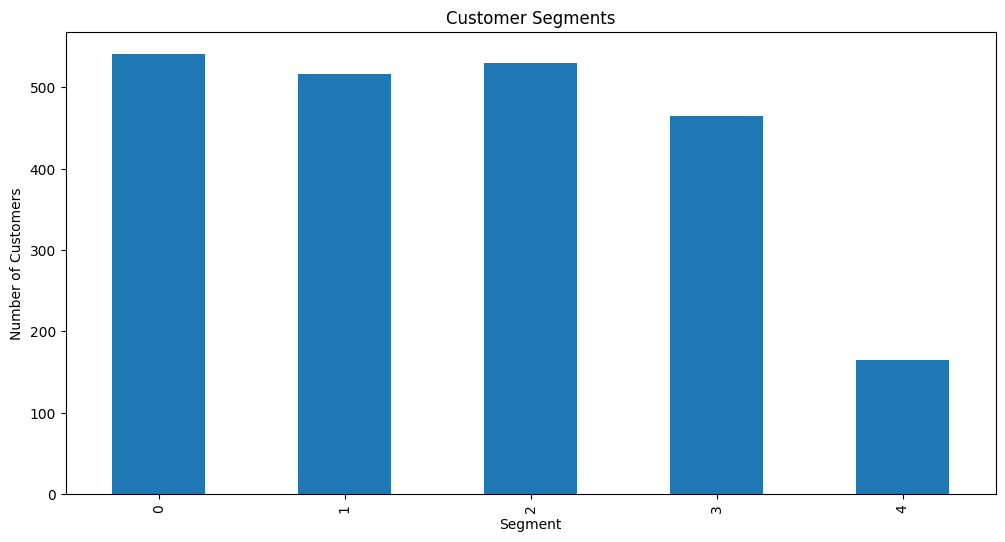

In [28]:
plt.figure(figsize=(12,6))
df['Segment'].value_counts().sort_index().plot(kind='bar')
plt.title("Customer Segments")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.show()

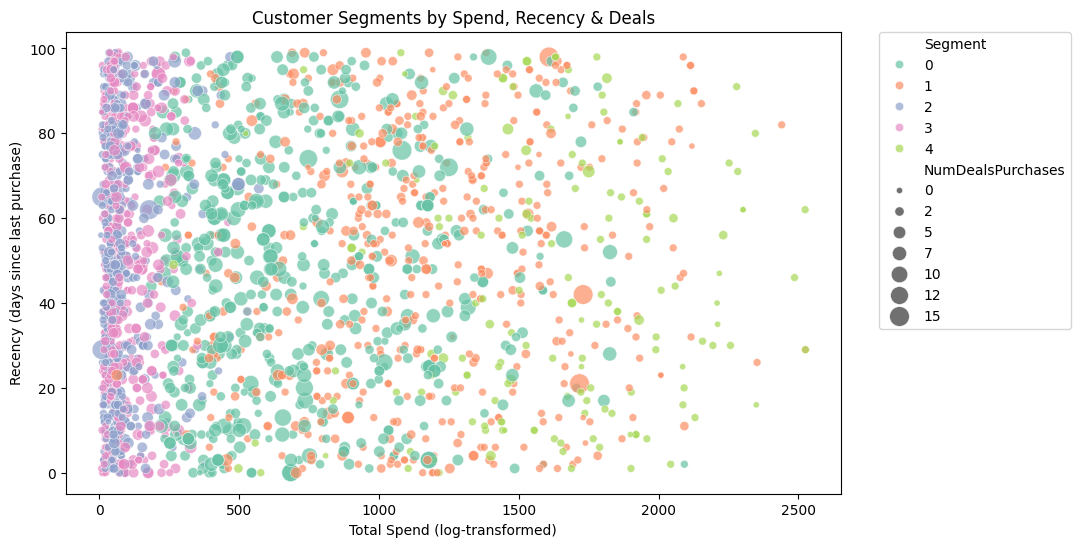

In [ ]:
# Optional: pick 3 main features for visualization
x_feature = 'TotalSpend'
y_feature = 'Recency'
size_feature = 'NumDealsPurchases'  # can use size to show deal activity

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x=x_feature,
    y=y_feature,
    hue='Segment',
    size=size_feature,
    palette='Set2',
    sizes=(20,200),
    alpha=0.7
)

plt.title('Customer Segments by Spend, Recency & Deals')
plt.xlabel('Total Spend (log-transformed)')
plt.ylabel('Recency (days since last purchase)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


## 8. Interpretation

- Segment 0

    - Count: 541 → largest group
    - Age: ~59 years, older customers
    - Income: ~$56k, middle income
    - Children: ~1
    - TotalSpend: 734 → moderately high
    - Recency: 48 days → recent buyers
    - NumWebPurchases: 6.7 → high online activity
    - NumStorePurchases: 7.4 → also buy in-store

- Segment 1

    - Count: 516
    - Age: 58 years, older
    - Income: ~$73k → higher income
    - Children: 0.3 → mostly no kids
    - TotalSpend: 1154 → highest spend
    - Recency: 51 days → slightly less recent than Seg 0
    - NumDealsPurchases: 1.5 → not heavily deal-driven
    - NumWebPurchases: 4.7 → moderate web
    - NumStorePurchases: 8.6 → mostly in-store
    - These are hypotheses—you’ll refine names by comparing cluster stats.

- Segment 2

    - Count: 530
    - Age: 48 years → younger
    - Income: ~$27k → low income
    - Children: ~1
    - TotalSpend: 85 → very low
    - Recency: 50 days → similar to others
    - NumDealsPurchases: 1.9 → some deal activity
    - NumWebPurchases: 2.1 → low
    - NumStorePurchases: 3 → low

- Segment 3

    - Count: 465
    - Age: 61 years → oldest
    - Income: ~$42k → mid-income
    - Children: 1.6 → mostly families
    - TotalSpend: 100 → low
    - Recency: 49 → recent-ish but low spend
    - NumWebPurchases / NumStorePurchases: ~2–3 → low engagement

- Segment 4

    - Count: 164 → smallest segment
    - Age: 55 years
    - Income: ~$80k → highest income
    - Children: 0.2 → mostly no kids
    - TotalSpend: 1589 → high
    - Recency: 44 → recent buyers
    - NumWebPurchases / NumStorePurchases: 5.8 / 7.9 → active